In [20]:
import cv2
from numpy import *
from matplotlib import pyplot as plt
import scipy.io as sio
loadfile = sio.loadmat("q1data.mat")
%matplotlib inline

image1 = loadfile['img1']
image2 = loadfile['img2']
data_with_outlier = loadfile['data_with_outlier']
data_without_outlier = loadfile['data_without_outlier']

In [21]:
image1_points = []
image2_points = []

for i in range(0,len(data_without_outlier[0])):
    image1_points.append((data_without_outlier[0][i],data_without_outlier[1][i],1))
    image2_points.append((data_without_outlier[2][i],data_without_outlier[3][i],1))

__Normalize the points__

In [24]:
def normalize_points(imagepoints):
    imagepoints = array(imagepoints)
    imagepoints = imagepoints.T
    finiteind = abs(imagepoints[2]) > finfo(float).eps
    imagepoints[0,finiteind] = imagepoints[0,finiteind]/imagepoints[2,finiteind]
    imagepoints[1,finiteind] = imagepoints[1,finiteind]/imagepoints[2,finiteind]
    imagepoints[2,finiteind] = 1
    centroid = [mean(imagepoints[0,finiteind]), mean(imagepoints[1,finiteind])]
    new_point0 = imagepoints[0, finiteind] - centroid[0]
    new_point1 = imagepoints[1, finiteind] - centroid[1]
    meandist = mean(sqrt(new_point0**2 + new_point1**2))
    scale = sqrt(2)/meandist
    T = eye(3)
    T[0][0] = scale
    T[1][1] = scale
    T[0][2] = -scale*centroid[0]
    T[1][2] = -scale*centroid[1]
    newpts = dot(T, imagepoints)
    return newpts, T

In [25]:
image1_points, T1 = normalize_points(image1_points)
image2_points, T2 = normalize_points(image2_points)

__Constraint Matrix__

In [26]:
def constraint_matrix(x1,x2):
    npts = x1.shape[1]
    A = c_[x2[0]*x1[0], x2[0]*x1[1], x2[0], x2[1]*x1[0], x2[1]*x1[1], x2[1], x1[0], x1[1], ones((npts,1))]
    return A

In [27]:
A = constraint_matrix(image1_points, image2_points)

In [28]:
(U, S, V) = linalg.svd(A)
V = V.conj().T;
F = V[:,8].reshape(3,3).copy()

# recall that F should be of rank 2, do the lower-rank approximation by svd
(U,D,V) = linalg.svd(F);
F = dot(dot(U,diag([D[0], D[1], 0])),V);

# denormalize
F = dot(dot(T2.T,F),T1)

In [29]:
F

array([[  6.05654811e-07,   1.16715948e-05,   1.91395643e-04],
       [ -9.54793477e-06,   8.97897885e-07,  -7.65491982e-03],
       [  5.47901703e-05,   5.03240183e-03,  -8.24263791e-02]])

In [30]:
image1_points = data_without_outlier[:2].T
image2_points = data_without_outlier[2:].T

In [31]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c,d = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(int64(pt1)),5,color,-1)
        img2 = cv2.circle(img2,tuple(int64(pt2)),5,color,-1)
    return img1,img2

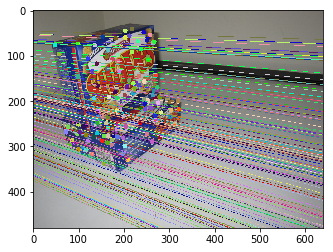

In [32]:
lines1 = cv2.computeCorrespondEpilines(image1_points.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(image1,image2,lines1,image1_points,image2_points)
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(image1_points.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(image2,image1,lines2,image2_points,image1_points)
plt.imshow(cv2.cvtColor(img5, cv2.COLOR_BGR2RGB))
plt.imsave('Image1.png',img5)
plt.show()


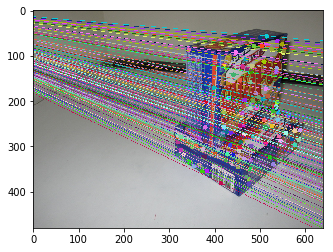

In [33]:
plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
plt.imsave('Image2.png',img3)
plt.show()

__The RANSAC implementation__

__Compute initial correspondences__

In [49]:
image1_points_Out = []
image2_points_Out = []

for i in range(0,len(data_without_outlier[0])):
    image1_points_Out.append((data_with_outlier[0][i],data_with_outlier[1][i],1))
    image2_points_Out.append((data_with_outlier[2][i],data_with_outlier[3][i],1))

In [50]:
initial1_points_Out = image1_points_Out[:10]
initial2_points_Out = image2_points_Out[:10]

In [52]:
image1_points_I, T1 = normalize_points(initial1_points_Out)
image2_points_I, T2 = normalize_points(initial2_points_Out)

In [59]:
image1_points_Out, T11 = normalize_points(image1_points_Out)
image2_points_Out, T22 = normalize_points(image2_points_Out)

In [53]:
A = constraint_matrix(image1_points_I, image2_points_I)

In [54]:
(U, S, V) = linalg.svd(A)
V = V.conj().T;
F = V[:,8].reshape(3,3).copy()

# recall that F should be of rank 2, do the lower-rank approximation by svd
(U,D,V) = linalg.svd(F);
F = dot(dot(U,diag([D[0], D[1], 0])),V);

# denormalize
F = dot(dot(T2.T,F),T1)

__Initial Matrix of F__

In [56]:
F

array([[ -2.42038480e-05,   7.08130941e-06,  -4.07469756e-04],
       [  4.13843093e-05,  -9.90598800e-06,  -6.88023501e-04],
       [  1.09878113e-04,  -5.95888172e-04,   3.56389654e-01]])

Function to evaluate the first order approximation of the geometric error
% (Sampson distance) of the fit of a fundamental matrix with respect to a
% set of matched points as needed by RANSAC.

In [57]:
t = 0.001

In [75]:
def get_error(data,F):
    
    data = data.T
    x1 = data[:3]
    x2 = data[3:6]
    
    
        
    # Sampson distance as error measure
    Fx1 = dot(F,x1)
    Fx2 = dot(F,x2)
    denom = Fx1[0]**2 + Fx1[1]**2 + Fx2[0]**2 + Fx2[1]**2
    err = ( diag(dot(x1.T,dot(F,x2))) )**2 / denom 
        
    # return error per point
    return err

In [76]:
get_error(image1_points_Out[:6],F)

[[-1.81882885 -1.1228467   1.        ]
 [-1.77829813 -0.97363133  1.        ]
 [-1.62305979 -1.43146408  1.        ]]


array([ 257611.68532823,  138590.65521926,  102971.36715325])